In [9]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [10]:
# watermark
%watermark -v -n -m -p numpy -g

Sat Feb 09 2019 

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 74ea6935a7ec80520bbeeedf062b16ddd5ae985d


# Ideas for notebook 
- execute data make file from notebook
- notebook will serve more as a dashboard and report 

# Load Data

SojernDataChallengeA large, multinational bank with branches in the US and UK would like to use digital advertising to drive moretraffic to their website to improve brand recognition. This bank has reached out to Sojern to manage theiradvertising campaigns, and your goal is to help the account manager (AM) who is working with the bank.One campaign that the AM is managing is a ​Search Campaign​. 

A search campaign is:●an ad,●a set of keywords that represent different search intents that match to that ad,●One bid per keyword which represents how much we are willing to pay for a click on that keyword.Whenever a user types a query into the search box that matches the keyword, an auction takes place. Themarketers with the winning bids then get their ad placed on the search results page in order of descending bidswhere the highest bid is put in position one, the next highest at position two and so on. Regardless of what webid, we only pay for the ad if the user clicks on the ad, and the amount we pay is equal to the bid price for thenext highest bid because SEM is second price auction. For more context, read sections 1,3,5 in this ​tutorial​.We have been running a nineteen keyword search campaign for the bank for the past three months. Your goalis to help the AM make better decisions for the next three months. The AM needs to know:●What metric(s) should we use to gauge performance?●Are there differences in how the keywords perform?●Is there a difference between US and UK performance? Can you prove it?●Should any keywords be removed from the campaign? If so, why?●Which keywords should have their bid increased? If so, why?Your deliverable is a jupyter notebook that has answers to these questions. Make sure to:●Document assumptions and any recommendations you’d make to the AM●Include useful plots, analysis or commentary to support your conclusions●If you do any data clean up, please document that as wellAlong with this document, you should have received a dataset called data_challenge.csv which has thefollowing 

## Data schema 
- date : date the data was recorded
- country : country the data was recorded for
- keyword : keyword associated with the campaign
- global_monthly_searches : total monthly searches for that keyword on google globally
- ad_position : how close to the top of the search result page the ad appeared (1 is the top)
- daily_clicks : number of clicks that occurred that day for the keyword
- daily_cost : amount of money spent for the clicks on that keyword on that day
- local_monthly_searches : total monthly searches for that keyword on google for the country
- impressions : number of times the ad was shown to a user that day for that keyword

In [27]:
data = pd.read_csv('data/raw/data_challenge.csv', index_col='date')
data.index = pd.DatetimeIndex(data.index)
data.head()

,country,keyword,global_monthly_searches,ad_position,daily_clicks,daily_cost,local_monthly_searches,impressions
date,,,,,,,,
2011-12-25,UK,financial services,4090000.0,1.0,8.0,234.22,246000.0,4757
2011-12-25,UK,certificate of deposit,1830000.0,1.0,148.0,159.49,201000.0,60635
2011-12-25,UK,joint account,201000.0,1.0,1.0,0.20,8100.0,26
2011-12-25,UK,insurance,33100.0,1.0,28.0,490.98,6600.0,34975
2011-12-25,UK,checking account,450000.0,1.0,50.0,133.00,33100.0,16997


In [42]:
data.tail()

,country,keyword,global_monthly_searches,ad_position,daily_clicks,daily_cost,local_monthly_searches,impressions
date,,,,,,,,
2012-05-31,US,lawyer,11100000.0,1.05,3734.0,4164.37,7480000.0,39916085
2012-05-31,US,credit cards,135000.0,1.05,189.0,1904.58,110000.0,925386
2012-05-31,US,loans,20400000.0,1.05,12031.0,72653.88,11100000.0,2243795028
2012-05-31,US,certificate of deposit,720.0,1.05,7.0,34.23,390.0,642
2012-05-31,US,wire transfer,6600.0,1.05,41.0,432.91,5400.0,46077


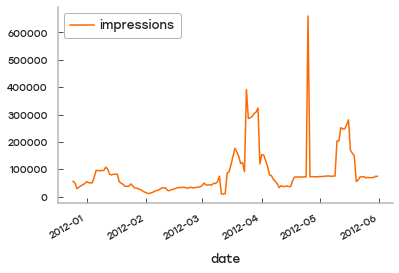

In [48]:
data[(data['country']=='UK') &  (data['keyword']=='lawyer')][['impressions']].plot();

In [15]:
data.describe()

,global_monthly_searches,ad_position,daily_clicks,daily_cost,local_monthly_searches,impressions
count,3.896000e+03,3898.000000,3916.000000,3900.00000,3.916000e+03,3.916000e+03
mean,3.247633e+06,1.017731,737.821502,4042.45178,9.838095e+05,6.587655e+07
std,6.072622e+06,0.023904,1918.515192,13628.77784,2.478468e+06,3.031724e+08
min,0.000000e+00,1.000000,0.000000,0.10000,0.000000e+00,2.600000e+01
25%,3.310000e+04,1.000000,7.000000,30.20000,5.400000e+03,7.702500e+02
50%,2.010000e+05,1.000000,78.000000,186.49500,1.100000e+05,4.708950e+04
75%,1.830000e+06,1.050000,318.250000,922.90250,3.010000e+05,5.483572e+05
max,2.040000e+07,1.100000,13299.000000,98244.74000,1.110000e+07,2.587009e+09
